In [ ]:
# En caso de problemas, utilizar las dependencias de librerías de este requierement: https://github.com/googlecolab/backend-info/blob/d6d345cb94fc5fd49951c9af0f6ead5e962bfab2/pip-freeze.txt
!pip install numpy==1.23.5
!pip install transformers[torch]==4.35.2
!pip install accelerate -U
!pip install evaluate
!pip install contractions

  Using cached transformers-4.35.2-py3-none-any.whl (7.9 MB)
  Using cached accelerate-0.29.3-py3-none-any.whl (297 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached n

In [ ]:
import pandas as pd
def load_prepare_data(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

# Ejercicio


En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Uno de los mayores problemas en el internet de hoy en día es la presencia de actitudes negativas hacia algunos colectivos en relación a su etnia, género, religión o ideología política. En este ejercicio trabajaremos con un conjunto de datos reales, etiquetados manualmente, procedentes de la plataforma [Kaggle](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data). Originalmente, a cada documento del dataset se le asignó una de las siguientes categorías:
- *religion*
- *age*
- *ethnicity*
- *gender*
- *other_cyberbullying*
- *not_cyberbullying*


El objetivo inicial del dataset era su uso para entrenar un modelo capaz de detectar el tipo de contenido de odio presente en internet según el colectivo al que se atacaba. En este caso, para simplificar el ejercicio, se ha generado una función `load_prepare_data()` que cambia las categorías del dataset obteníendose al final 2 categorías con valor 1 o 0, indicando si el tweet tiene contenido de odio

**En este ejercicio debeis entrenar un modelo de clasificación utilizando la librería Transformers.** Dado que el análisis exploratorio ha sido realizado en el ejercicio anterior, en este caso podréis centraros en entrenar el modelo utilizando la librería Transformers, seleccionando un modelo pre-entrenado adecuado, entrenando el modelo y llevando a cabo la evaluación.


**Nota 1**: Este ejercicio requiere el uso de las GPUs de Google Colab. Este Colab debería estar preconfigurado para ejecutarse en GPU, pero si tuviera problemas en la ejecución que me contacte a través del Moodle para buscar soluciones alternativas.

## 0. Imports


In [ ]:
from transformers import (
   AutoConfig,
   AutoTokenizer,
   AutoModelForSequenceClassification,
   AdamW
)
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

import contractions

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `load_prepare_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [ ]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
# Path de datos alternativos en caso de que el anterior no funcione (al estar alojado en github puede haber limitaciones
# en la descarga.
# path_data = "https://zenodo.org/records/10938455/files/cyberbullying_tweets.csv?download=1"
dataset = load_prepare_data(path_data)

In [ ]:
dataset.head(4)

,tweet_text,cyberbullying
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0


## 2. Análisis exploratorio

Podéis saltarlo en este ejercicio.

## 3. Preprocesado y Normalización

Para el pre procesado y normalización, utilizaremos la funcion del primer ejercicio, esta nos permitirá eliminar espacios adicionales, transformar a minúsculas, y transformar la contracciones de palabras.

In [ ]:
def normalizar(text):
    # Limpiar textos/tweets
    text = " ".join(text.split())
    text = text.lower()
    text = contractions.fix(text, slang=True)

    return text

Prueba de funcionamiento de la formula normaliza con el tweet text #18

In [ ]:
dataset["tweet_text"][18] #prueba de funcionamiento

"Best pick up line? Hi, you're cute... ?: I love how people call James Potter is a bully. - mypatronusisyou: http://tumblr.com/xol3xl14zy"

In [ ]:
normalizar(dataset["tweet_text"][18])

'best pick up line? hi, you are cute... ?: i love how people call james potter is a bully. - mypatronusisyou: http://tumblr.com/xol3xl14zy'

Procesamos todas las filas con la formula normalizar

In [ ]:
dataset["normalized"] = dataset["tweet_text"].apply(lambda x: normalizar(x))

In [ ]:
dataset.head(5)

,tweet_text,cyberbullying,normalized
0,"In other words #katandandre, your food was cra...",0,"in other words #katandandre, your food was cra..."
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,why is #aussietv so white? #mkr #theblock #ima...
2,@XochitlSuckkks a classy whore? Or more red ve...,0,@xochitlsuckkks a classy whore? or more red ve...
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,"@jason_gio meh. :p thanks for the heads up, bu..."
4,@RudhoeEnglish This is an ISIS account pretend...,0,@rudhoeenglish this is an isis account pretend...


## 4. Vectorización

Procedemos a separar nuestras variables predictoras (text) de la target (labels).

In [ ]:
texts = dataset.normalized.values  # an array of strings
labels = dataset.cyberbullying.values  # an array of integers

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels,
                                                                      test_size=.25,
                                                                      random_state=93,
                                                                      stratify = labels)

Datos para validacion del modelo.

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels,
                                                                    test_size=.2,
                                                                    random_state=93,
                                                                    stratify = train_labels)

Seleccionamos el modelo con el que trabajaremos, en este caso y como se vio en la clase sera el de arquitectura bert. Se intento realizar el modelo con 'large' en vez de 'base' pero tarda mucho a la hora de entrenar.

In [ ]:
model_name = 'bert-base-uncased'

Para cargar automáticamente el tokenizador del modelo pre-entrenado, en este caso del modelo 'bert-base-uncased, utilizamos la clase 'AutoTokenizer' y el metodo 'from_pretrained'.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Realizamos una pequeña comprobación del tokenizador del modelo, lo que nos devuelve es una lista con los tokens incluynedo 2 tokens especiales [CLS] y [SEP]. Ademas podemos observar como se encarga el tequenizador de procesar el texto.

In [ ]:
texto = dataset["normalized"][18]
texto_tokens = tokenizer(texto).tokens()
texto_tokens

['[CLS]',
 'best',
 'pick',
 'up',
 'line',
 '?',
 'hi',
 ',',
 'you',
 'are',
 'cute',
 '.',
 '.',
 '.',
 '?',
 ':',
 'i',
 'love',
 'how',
 'people',
 'call',
 'james',
 'potter',
 'is',
 'a',
 'bully',
 '.',
 '-',
 'my',
 '##pa',
 '##tron',
 '##us',
 '##is',
 '##you',
 ':',
 'http',
 ':',
 '/',
 '/',
 'tu',
 '##mb',
 '##lr',
 '.',
 'com',
 '/',
 'x',
 '##ol',
 '##3',
 '##x',
 '##l',
 '##14',
 '##zy',
 '[SEP]']

Vectorización del modelo

In [ ]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Constructor de la clase CustomDataset.
        Parámetros:
        - texts: Lista de textos.
        - labels: Lista de etiquetas correspondientes a los textos.
        - tokenizer: Objeto del tokenizador a utilizar.
        - max_length: Longitud máxima de la secuencia después de la tokenización.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """
        Devuelve la longitud del conjunto de datos.
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Obtiene un elemento del conjunto de datos.

        Parámetros:
        - idx: Índice del elemento a obtener.

        Devuelve:
        Un diccionario con 'input_ids', 'attention_mask' y 'labels'.
        """
        # Obtener el texto y la etiqueta del índice proporcionado
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        # Tokenizar el texto
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        # Devolver el diccionario con los datos
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
Parametros que se utilizaran a la hora de

In [ ]:
max_length = 150  # Puedes ajustar esto según tus necesidades

train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length)

Estos valores son la cantidad de ejemplos de entrenamiento que se utilizan en una iteración de optimización durante el entrenamiento del modelo. Un tamaño valor puede acelerar el entrenamiento, por lo que lo coloque en 35 ya que es el vlaor que no me daba error en cuanto a la memoria de la GPU.

In [ ]:
max_seq_length = 150 #@param {type: "integer"}
train_batch_size = 35 #@param {type: "integer"}
eval_batch_size = 35 #@param {type: "integer"}
test_batch_size = 35 #@param {type: "integer"}

En este codigo se carga el modelo preentrenado para clasificación, con las etiquetas "NO_cyberbullying" y "cyberbullying".

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

id2label = {0: "NO_cyberbullying", 1: "cyberbullying"}
label2id = {"NO_cyberbullying": 0, "cyberbullying": 1}
model = AutoModelForSequenceClassification.from_pretrained(model_name,  num_labels=2, id2label=id2label, label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import accelerate

training_args = TrainingArguments(
    output_dir="modelo_test",
    learning_rate=2e-5,
    per_device_train_batch_size=35,
    per_device_eval_batch_size=35,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False
)

In [ ]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)
    f1_score_value = f1_score.compute(predictions=predictions, references=labels)

    return {
        "accuracy": accuracy_value,
        "f1_score": f1_score_value,
    }

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


## 5. Entrenamiento y evaluación de modelos


Entrenamos el modelo con unicamente 2 epocas, mas epocas mejora la clasificación pero tarda mucho mas.

Lo que obtenemos es un accuracy en la primera epoca de 0.89.

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.289500,0.239073,{'accuracy': 0.8932065977075762},{'f1': 0.937987012987013}
2,0.199600,0.246643,{'accuracy': 0.888034665921163},{'f1': 0.9341770071493138}


Trainer is attempting to log a value of "{'accuracy': 0.8932065977075762}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.937987012987013}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.888034665921163}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9341770071493138}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=1636, training_loss=0.23509688598893966, metrics={'train_runtime': 1604.2234, 'train_samples_per_second': 35.675, 'train_steps_per_second': 1.02, 'total_flos': 4411478231910000.0, 'train_loss': 0.23509688598893966, 'epoch': 2.0})

In [ ]:
# Make predictions on the test data
trainer.evaluate(test_dataset)

Trainer is attempting to log a value of "{'accuracy': 0.891050910005871}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9366743040998392}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.24092242121696472,
 'eval_accuracy': {'accuracy': 0.891050910005871},
 'eval_f1_score': {'f1': 0.9366743040998392},
 'eval_runtime': 115.8408,
 'eval_samples_per_second': 102.926,
 'eval_steps_per_second': 2.944,
 'epoch': 2.0}

In [ ]:
# Make predictions on the test data
predictions = trainer.predict(test_dataset)

In [ ]:
predictions[0][0]

array([-2.887713 ,  3.3366723], dtype=float32)

In [ ]:
# Access the predicted labels
y_pred = predictions.predictions.argmax(axis=1)

In [ ]:
y_true = [x["labels"].item() for x in test_dataset]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[1017  969]
 [ 330 9607]]
              precision    recall  f1-score   support

           0       0.76      0.51      0.61      1986
           1       0.91      0.97      0.94      9937

    accuracy                           0.89     11923
   macro avg       0.83      0.74      0.77     11923
weighted avg       0.88      0.89      0.88     11923



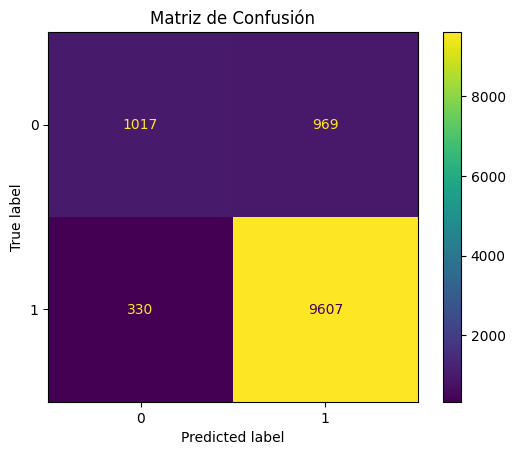

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Crear matriz de confusión
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred)).plot()

# Mostrar la matriz de confusión
plt.title('Matriz de Confusión')
plt.show()

Lo que podemos observar es que las metricas de medicion son muy buenas, tenemos buena clasificacion en general con f1 score de 0.61 (no_cyberbullyng) y 0.94 (bullyng).

In [ ]:
# Create a function to predict for a single document
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict_single_document(document, max_length=128):
    # Tokenize the input document
    inputs = tokenizer(document, return_tensors="pt", max_length=max_length, truncation=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move tensors to the same device as the model

    # Make the prediction
    with torch.no_grad():
      model_output = trainer.model(**inputs)

    # Access the predicted labels
    predicted_label = torch.argmax(model_output.logits).item()

    return predicted_label

In [ ]:
#@markdown >Escribe el texto que quieras clasificar
input_text1 = 'Whats wrong with you, you are going to regret doing it'
input_text2 = 'I hate being so cute'

pred1 = predict_single_document(input_text1)
pred2 = predict_single_document(input_text2)

# label_mapping = {0:"no molesto",1:"molesto"}

print("Clase texto 1: {}".format(pred1))
print("Clase texto 2: {}".format(pred2))

Clase texto 1: 0
Clase texto 2: 0


# Comparacion de los modelos:

Matriz de confusión Modelo de Lenguaje:

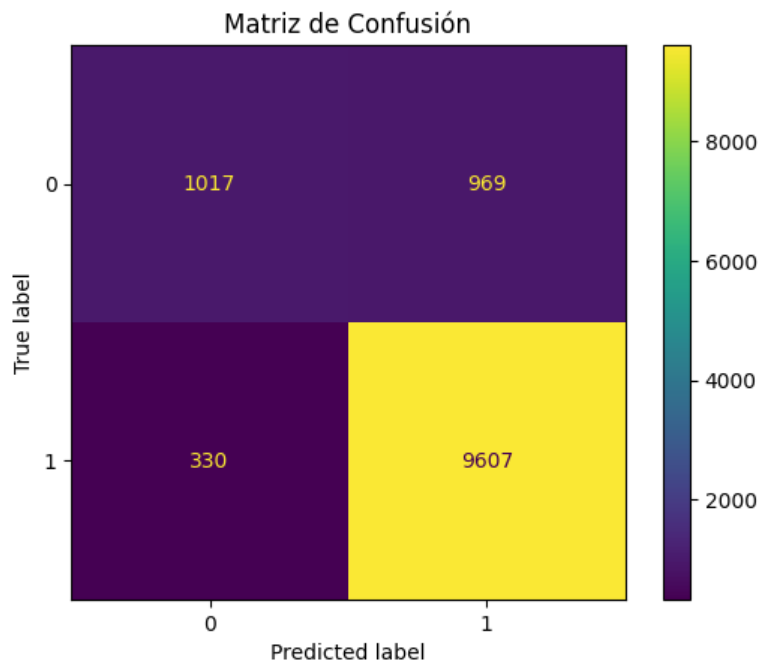


Matriz de confusión: Random Forest Classifier:

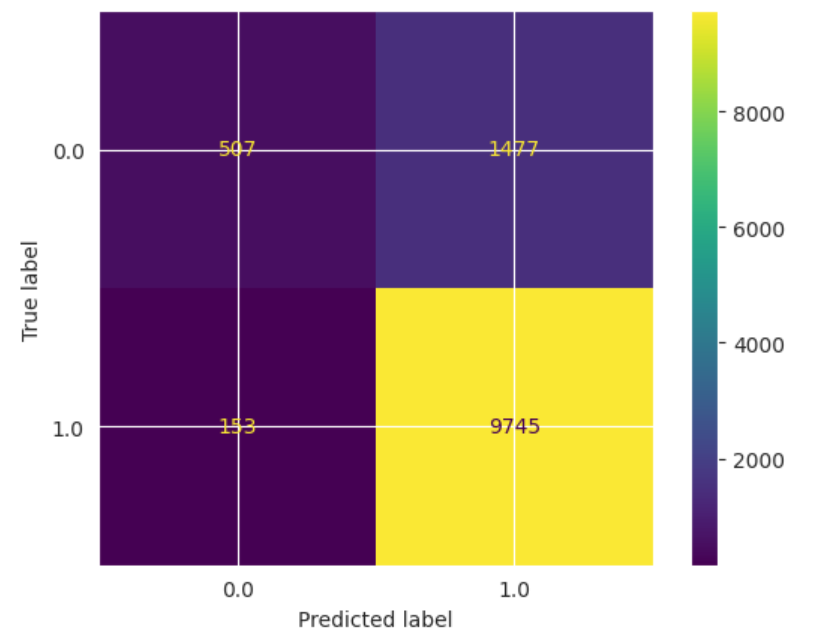

### Métricas:

- **Accuracy**: Lo que podemos observar es que, el modelo de lenguaje se desempeño mejor realizando una predicción de los valores que, en efecto, eran `True positive` para ambas etiquetas.
  
  Random Forest Classifier (0.86)

  Modelo de Lenguaje (0.89)

- **Recall**: Este parametro nos indica que tan bien ha podido el modelo clasificar los verdaderos positivos de todo lo que era positivo. Un recall alto en esta clase significa que el modelo identifica la mayoría de los casos de "bullying" reales.

  Random Forest Classifier: el recall para los casos con etiquetas 0 (no_cyberbullying) fue de 0.26 lo que significa que muchos casos fueron considerados como bullying reales cuando no lo eran. En el Modelo de Lenguaje este valor mejoro a (0.51)

- **Precision**: Esta metrica nos permite identificar de todos los casos que era no_bullying y bullying, cuantos de ellos eran realmente dicha etiqueta.
  
  El modelo de lenguaje tuvo un valor de (0.76) y (0.91) respectivamente. Esto en comparación con el primer modelo que en la etiqueta de no_cyberbullying fui ligeramente mayor (0.78) pero las etiquetas de bullyng tuvieron un valor menor de (0.87).
